# 19.2 Predicting House Prices Assignment
Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.

## Import the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Data Cleaning and Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

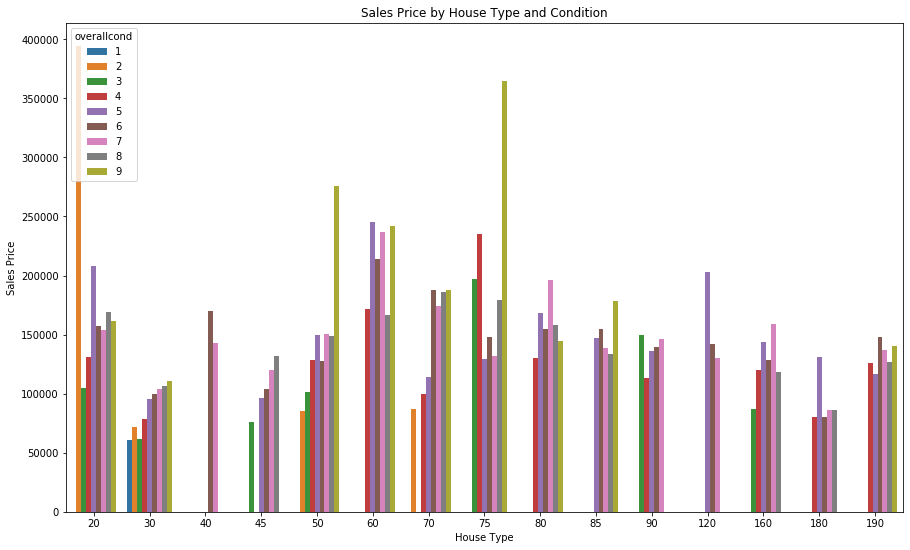

In [23]:
avg_subclass = df.groupby(['mssubclass', 'overallcond'], as_index=False).mean()

plt.figure(figsize=(15, 9))
sns.barplot(avg_subclass['mssubclass'], avg_subclass['saleprice'], hue=avg_subclass['overallcond'])

plt.title('Sales Price by House Type and Condition')
plt.ylabel('Sales Price')
plt.xlabel('House Type')

plt.show()

### Interpreting the Chart
As expected the higher the overall quality the higher the price for each type of house for sale. 

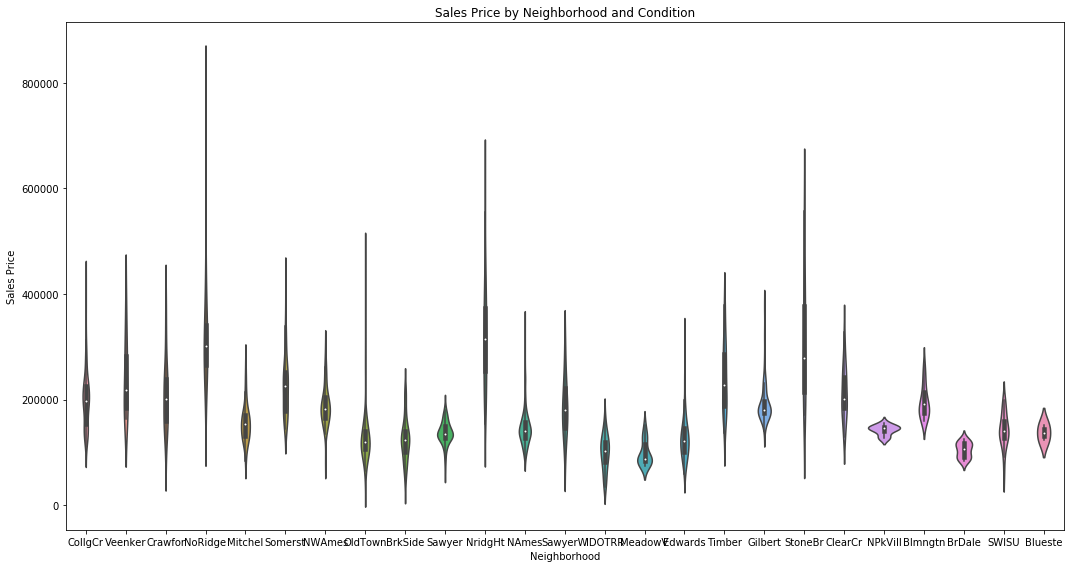

In [20]:
plt.figure(figsize=(15, 8))
sns.violinplot(df['neighborhood'], df['saleprice'])

plt.title('Sales Price by Neighborhood and Condition')
plt.ylabel('Sales Price')
plt.xlabel('Neighborhood')

plt.tight_layout()
plt.show()

### Interpreting the Chart
The violiln plot above shows that the majority of the prices were below the 200k range for most neighborhoods. There were several neighborhoods identified with higher prices but they had low inventory volume. 

In [8]:
house_corr = df.corr()
print(house_corr['saleprice'])

id              -0.021917
mssubclass      -0.084284
lotfrontage      0.351799
lotarea          0.263843
overallqual      0.790982
overallcond     -0.077856
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.477493
bsmtfinsf1       0.386420
bsmtfinsf2      -0.011378
bsmtunfsf        0.214479
totalbsmtsf      0.613581
firstflrsf       0.605852
secondflrsf      0.319334
lowqualfinsf    -0.025606
grlivarea        0.708624
bsmtfullbath     0.227122
bsmthalfbath    -0.016844
fullbath         0.560664
halfbath         0.284108
bedroomabvgr     0.168213
kitchenabvgr    -0.135907
totrmsabvgrd     0.533723
fireplaces       0.466929
garageyrblt      0.486362
garagecars       0.640409
garagearea       0.623431
wooddecksf       0.324413
openporchsf      0.315856
enclosedporch   -0.128578
threessnporch    0.044584
screenporch      0.111447
poolarea         0.092404
miscval         -0.021190
mosold           0.046432
yrsold          -0.028923
saleprice        1.000000
Name: salepr

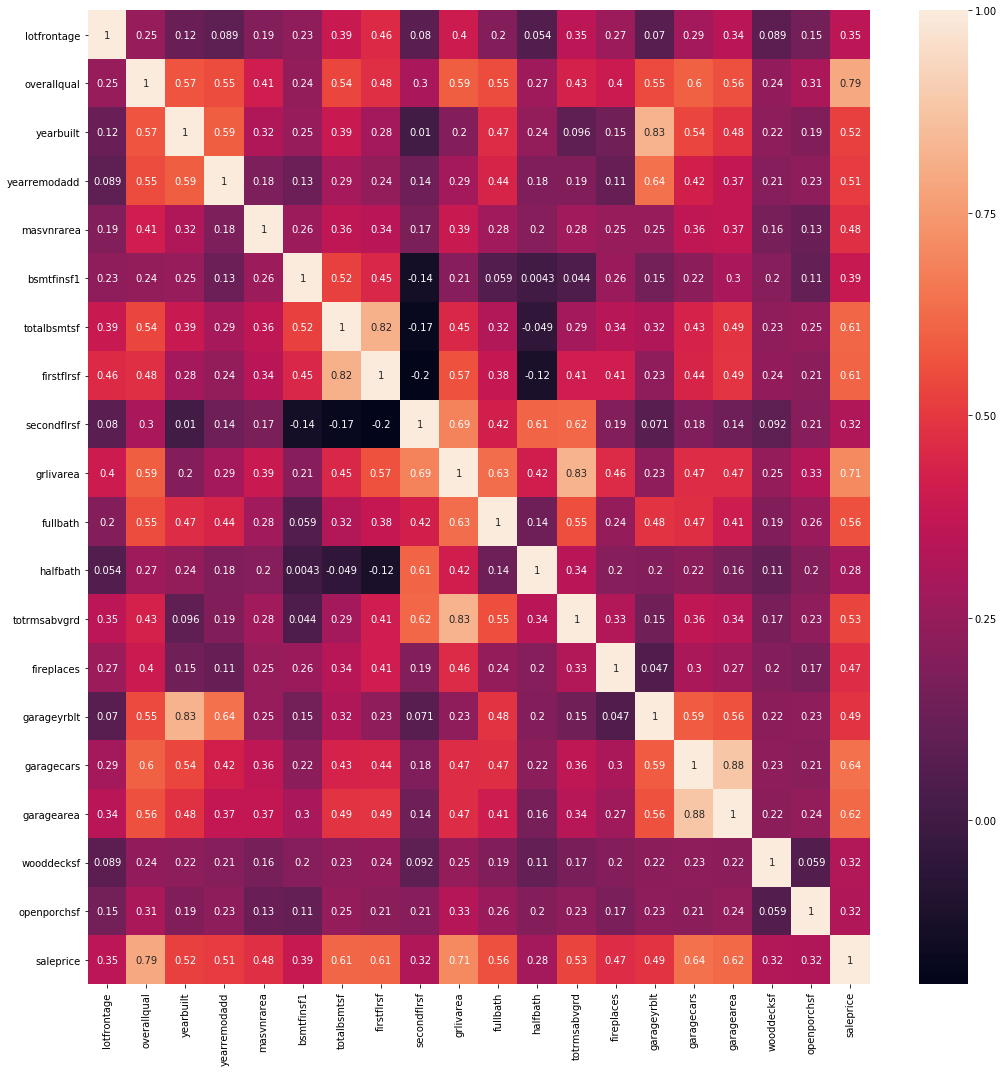

In [9]:
# Remove variables with low correlation <.25
df2 = df.drop(['id', 'mssubclass', 'overallcond', 'lotarea', 'bsmtfinsf2', 
                'bsmtunfsf', 'lowqualfinsf', 'bsmtfullbath', 'bsmthalfbath', 
                'bedroomabvgr','kitchenabvgr', 'enclosedporch', 'threessnporch', 
                'screenporch','poolarea', 'miscval', 'mosold', 'yrsold'], axis=1)

plt.figure(figsize=(15,15))
sns.heatmap(df2.corr(), annot=True)
plt.tight_layout()
plt.show()

## Regression Model
Looking at the correlation of the values above the biggest indicators of sales price is overall quality, total basement square feet, first floor square feet, living area square feet, garage car capacity, and garage square feet. 

In [10]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'totalbsmtsf', 'firstflrsf', 'grlivarea',
      'garagecars', 'garagearea']]

# Linear Regression model object
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.39970394e+04 2.43907676e+01 1.11859135e+01 4.31228864e+01
 1.45151932e+04 1.56639341e+01]

Intercept: 
 -102650.90069029017


In [11]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     775.0
Date:                Thu, 15 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:56:36   Log-Likelihood:                -17496.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1453   BIC:                         3.504e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.027e+05   4903.994    -20.932      0.000   -1.12e+05    -9.3e+04
overallqual    2.4e+04   1083.393     22.150      0.000    2.19e+04    2.61e+04
totalbsmtsf    24.3908      4.318      5.649      0.000      15.921      32.860
firstflrsf     11.1859      5.032      2.223      0.026       1.315      21.057
grlivarea      43.1229      2.679     16.095      0.000      37.867      48.379
garagecars   1.452e+04   3018.621      4.809      0.000    8593.872    2.04e+04
garagearea     15.6639     10.475      1.495      0.135      -4.884      36.212
==============================================================================
Omnibus:                      431.781   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39208.253
Skew:                          -0.313   Prob(JB):                         0.00
Kurtosis:                      28.380   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""